In [1]:
import numpy as np
import torch
import adversary.cw as cw
from adversary.jsma import SaliencyMapMethod
from adversary.fgsm import Attack
import torchvision
import torch.nn.functional as F
import torch.utils.data as Data
from models.mnist_model import MnistModel, MLP
from torchvision import transforms
import mnist_undercover_train

%reload_ext autoreload
%autoreload 2

In [2]:
train_eps = 0.1
classifier_train_epochs = 30
train_classifier = False

In [3]:
MNIST_UNDERCOVER_CKPT = './checkpoint/mnist_undercover.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
if train_classifier == True:
    mnist_undercover_train.train(classifier_train_epochs, train_eps, device)

In [5]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

mlp = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)


undercoverNet = MnistModel().to(device)
checkpoint = torch.load(MNIST_UNDERCOVER_CKPT, map_location=torch.device(device))
undercoverNet.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4)
trainiter = iter(trainloader)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=4)
testiter = iter(testloader)

# Use BIM attack

In [7]:
undercover_gradient_attacker = Attack(undercoverNet, F.cross_entropy)

In [8]:
craft_eps = 0.1

In [9]:
# construct bim adversarial samples
# --------------------train---------------------
normal_samples, adversarial_samples = [], []
for x, y in trainloader:
    x, y = x.to(device), y.to(device)
    y_pred = undercoverNet(x).argmax(dim=1)
    
    #eps = 0.3
    x_adv = undercover_gradient_attacker.i_fgsm(x, y, eps=craft_eps, alpha=1/255, iteration=int(min(craft_eps*255 + 4, 1.25*craft_eps*255)))
    #x_adv = undercover_gradient_attacker.fgsm(x, y, False, eps=craft_eps)
    y_pred_adv = undercoverNet(x_adv).argmax(dim=1)
    selected = (y == y_pred) & (y != y_pred_adv)
    normal_samples.append(x[selected].detach().cpu())
    adversarial_samples.append(x_adv[selected].detach().cpu())
#     break

normal_x = torch.cat(normal_samples, dim=0)
adversarial_x = torch.cat(adversarial_samples, dim=0)
normal_y = torch.zeros(normal_x.shape[0]).long()
adversarial_y = torch.ones(adversarial_x.shape[0]).long()

dba_trainloader = Data.DataLoader(Data.TensorDataset(torch.cat([normal_x, adversarial_x], dim=0),
                                           torch.cat([normal_y, adversarial_y], dim=0)), 
                                  batch_size=512, shuffle=True, num_workers=4)
dba_trainiter = iter(dba_trainloader)
print(normal_x.shape)
print(adversarial_x.shape)

# ----------------test---------------------
normal_samples, adversarial_samples = [], []
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_pred = undercoverNet(x).argmax(dim=1)
    
    #eps = 0.3
    x_adv = undercover_gradient_attacker.i_fgsm(x, y, eps=craft_eps, alpha=1/255, iteration=int(min(craft_eps*255 + 4, 1.25*craft_eps*255)))
    #x_adv = undercover_gradient_attacker.fgsm(x, y, False, eps=craft_eps)
    y_pred_adv = undercoverNet(x_adv).argmax(dim=1)
    selected = (y == y_pred) & (y != y_pred_adv)
    normal_samples.append(x[selected].detach().cpu())
    adversarial_samples.append(x_adv[selected].detach().cpu())
#     break

normal_x = torch.cat(normal_samples, dim=0)
adversarial_x = torch.cat(adversarial_samples, dim=0)
normal_y = torch.zeros(normal_x.shape[0]).long()
adversarial_y = torch.ones(adversarial_x.shape[0]).long()

dba_testloader = Data.DataLoader(Data.TensorDataset(torch.cat([normal_x, adversarial_x], dim=0),
                                           torch.cat([normal_y, adversarial_y], dim=0)), 
                                  batch_size=1024, shuffle=True, num_workers=4)
dba_testiter = iter(dba_testloader)
print(normal_x.shape)
print(adversarial_x.shape)

torch.Size([4861, 1, 28, 28])
torch.Size([4861, 1, 28, 28])
torch.Size([842, 1, 28, 28])
torch.Size([842, 1, 28, 28])


In [14]:
# train the mlp
epochs = 10
for i in range(epochs):
    train_loss = 0
    correct, total = 0, 0
    for x, y in dba_trainloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        _, V1 = undercoverNet(x, dba=True)
        undercover_adv = undercover_gradient_attacker.fgsm_l2(x, y, False, craft_eps)#1/255)
        _, V2 = undercoverNet(undercover_adv, dba=True)
        V = torch.cat([V1, V2, V1 - V2, V1 * V2], axis=-1)
        y_pred = mlp(V)
        total += y.size(0)
        correct += y_pred.argmax(dim=1).eq(y).sum().item()
        
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        #print('epoch: %d, train loss: %.2f, train acc: %.4f' % (epoch, train_loss, acc))
        loss.backward()
        optimizer.step()
    acc = 1.0 * correct / total
    print('epoch: %d, train loss: %.2f, train acc: %.4f' % (i, train_loss, acc))
    #print('epoch: %d, train loss: %.2f' % (i, train_loss))

epoch: 0, train loss: 3.08, train acc: 0.9427
epoch: 1, train loss: 2.27, train acc: 0.9720
epoch: 2, train loss: 1.96, train acc: 0.9822
epoch: 3, train loss: 1.83, train acc: 0.9858
epoch: 4, train loss: 1.81, train acc: 0.9846
epoch: 5, train loss: 1.80, train acc: 0.9858
epoch: 6, train loss: 1.78, train acc: 0.9858
epoch: 7, train loss: 1.78, train acc: 0.9860
epoch: 8, train loss: 1.80, train acc: 0.9837
epoch: 9, train loss: 1.97, train acc: 0.9792


In [37]:
eval_eps = 50

In [43]:
# test
accuracies = []
epsilons = np.linspace(0.01, 50, 50)
for eps in epsilons:
    total, correct = 0, 0
    FP, TP, FN, TN = 0, 0, 0, 0 
    for x, y in dba_testloader:
        x, y = x.to(device), y.to(device)
        _, V1 = undercoverNet(x, dba=True)
        undercover_adv = undercover_gradient_attacker.fgsm_l2(x, y, False, eps)
        _, V2 = undercoverNet(undercover_adv, dba=True)
        V = torch.cat([V1, V2, V1 - V2, V1 * V2], axis=-1)
        y_pred = mlp(V).argmax(dim=1)
        
        total += y.size(0)
        #print(y_pred)
        confusion_vector = y_pred / y
        TP += torch.sum(confusion_vector == 1).item()
        FP += torch.sum(confusion_vector == float('inf')).item()
        TN += torch.sum(torch.isnan(confusion_vector)).item()
        FN += torch.sum(confusion_vector == 0).item()
        correct += y_pred.eq(y).sum().item()
        #break
    #print('TP=', TP, 'FP=', FP, 'TN=', TN, 'FN=', FN)
    Prec = TP/(TP+FP)
    Recall =  TP/(TP+FN)
    accuracies.append(100*(TP+TN)/(TP+TN+FP+FN))
    #break
    #print('Precision=', Prec)
    #print('Recall=', Recall)
    #print('F1=', 2*Recall*Prec/(Recall + Prec))
    #print('Accuracy=', (TP+TN)/(TP+TN+FP+FN))

Text(0, 0.5, 'Scale (Bananas)')

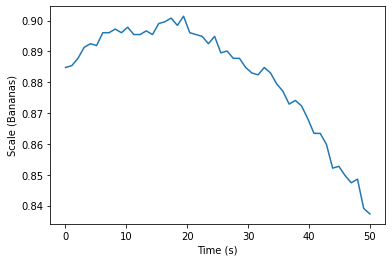

In [44]:
from matplotlib import pyplot as plt
plt.plot(epsilons, accuracies)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")